# [E-07] 👩🏻 인물 사진을 만들어 보자.

In [59]:
# $ mkdir -p ~/aiffel/human_segmentation/models
# $ mkdir -p ~/aiffel/human_segmentation/images

## 인물사진 모드 (portrait mode)
- DSLR에서는 피사계 심도(depth of field, DOF)를 얕게 해 피사체를 제외한 배경을 흐리게 함
- 핸드폰 인물사진 모드는 화각이 다른 두 렌즈를 이용해, **일반(광각) 렌즈에선 배경을 촬영**하고, 망원 렌즈에서는 인물을 촬영한 뒷배경을 흐리게 처리한 후 **망원 렌즈의 인물**과 적절하게 합성함

## 1. 사진 준비하기
#### 하나의 카메라로 셸로우 포커스(shallow focus)를 만드는 방법
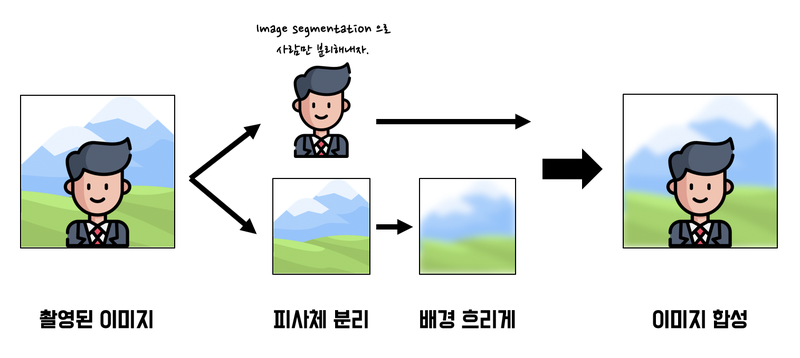
2개 이상의 렌즈를 탑재한 최신 핸드폰에서 `인물사진 모드(portrait mode)`가 지원된다. 한국에선 배경을 흐리게 하는 기술을 '아웃포커싱'이라 표현하지만 이는 한국에서만 표현하는 용어이고, 정확한 영어 표현은 얕은 피사계 심도(shallow depth of field) 또는 `셸로우 포커스`(shallow focus)라고 한다. <br/><br/>

두 개의 렌즈가 맡은 역할을 하나의 렌즈에서 구현해야 한다. `이미지 세그멘테이션(image segmentation)` 기법을 통해 하나의 이미지에서 배경과 사람을 분리할 수 있다. **분리된 배경을 블러(blur)처리** 후 사람 이미지와 다시 **합치면** shallow focus 효과를 거친 인물 사진을 얻을 수 있다. <br/><br/>

다음과 같이 후가공으로 인물사진 모드를 적용해보자.
1. 배경이 있는 셀카 촬영
2. semantic segmentation으로 피사체(사람)과 배경을 분리하기
3. blurring 기술로 배경 흐리게 하기
4. 피사체를 배경의 원래 위치에 합성하기

#### 라이브러리 불러오기

In [60]:
import os
import urllib # 웹에서 데이터 다운로드 할 때
import cv2 # opencv - 이미지 처리
import numpy as np
from pixellib.semantic import semantic_segmentation # 준비된 모델 사용하기
from matplotlib import pyplot as plt

#### 준비된 이미지 읽기

(720, 1080, 3)


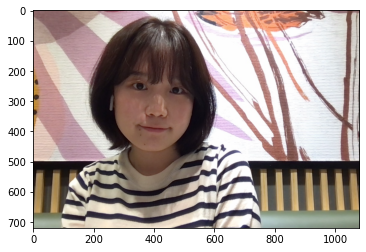

In [61]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/me2.png'  
img_orig = cv2.imread(img_path)

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

## 2. 세그멘테이션으로 사람 분리하기

배경에 blur 처리를 하기 위해서는 **이미지에서 사람과 피사체 분리**하자.

### 🧤 세그멘테이션(segmentation)이란?
이미지에서 `픽셀` 단위로 관심 객체를 추출하는 방법. 이미지 세그멘테이션은 모든 픽셀에 **라벨(label)을 할당**하고 같은 라벨은 '공통적인 특징'을 가진다고 가정한다. 세그멘테이션에는 여러 가지 세부 태스크가 있고, 태스크에 따라 다양한 기준으로 객체를 추출한다. <br/>

### 🧤 시맨틱 세그멘테이션(sementic segementation)이란?
우리가 인식하는 세계처럼 `물리적 의미 단위`로 인식하는 세그멘테이션. 예를 들어 이미지에서 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 분류(classification)하는 방법 <br/>

### 🧤 인스턴스 세그멘테이션(Instance segmentation)이란?
시맨틱 세그멘테이션은 '사람'이란 추상적 정보에서 이미지를 추출해내는 것이므로 사람이 누군지 관계없이 같은 라벨로 표현된다. 인스턴스 세그멘테이션은 사람 **개개인별로 다른 라벨을 갖게 해** 여러 사람이 한 이미지에 등장할 때 각 개체를 분할해 인식하는 것이 목표이다. <br/><br/>

##### 딥런이 기반 이전에는 어떻게 segmentation 했을까?
### 🧤 워터쉐드 세그멘테이션(watershed segmentation)
이미지에서 영역을 분할하는 가장 간단한 방법: 물체의 '경계' 나누기 <br/>
이미지는 그레이스케일(grayscale)의 0~255로 변환하면 이 픽셀 값을 이용해 각 위치의 높고 낮음을 구분할 수 있다.

## 3. 시맨틱 세그멘테이션 다뤄보기
FCN, SegNet, U-Net 등의 다양한 모델 중 `DeepLab`이란 세그멘테이션 모델을 사용해보자. PixelLib에서 [DeepLab][1] 모델을 이용할 수 있다.

[1]:https://github.com/ayoolaolafenwa/PixelLib

#### PixelLib에서 제공해주는 모델 다운로드 하기

In [62]:
# 저장할 파일 이름 결정
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f79c0048eb0>)

#### 다운받은 모델을 통해 PixelLib으로 우리가 사용할 세그멘테이션 모델 생성

In [63]:
model = semantic_segmentation() # 분할을 수행하는 클래스 인스턴스 생성
model.load_pascalvoc_model(model_file)

#### 모델에 이미지 입력하기

In [64]:
segvalues, output = model.segmentAsPascalvoc(img_path)

> #### ❓ segmentAsPascalvoc?
Pascal Voc 데이터로 학습된 모델을 이용하겠다. 모델마다 학습시킨 데이터에 따라 결괏값이 다르므로 어떤 데이터를 학습시켰는지 확인하는 게 중요하다.

> #### 🧤 PASCAL VOC란?
대표적인 Object Detection dataset 중 하나
http://host.robots.ox.ac.uk/pascal/VOC/

#### Pascal Voc 데이터의 라벨 종류

In [65]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

'background'를 제외하면 20개의 클래스가 있음. <br/>
우린 이 중 person라벨, 즉 15를 가진 영역만 검출하고 싶다.

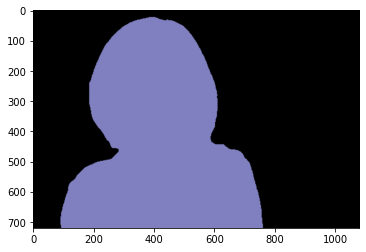

In [66]:
plt.imshow(output)
plt.show()

`output`에는 세그멘테이션 결과가 각각 다른 색으로 담긴 것을 확인할 수 있다.

In [67]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [68]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id]) # 0과 15를 LABEL_NAMES에서

background
person


`segvalues`에는 `class_ids`와 `masks`가 있다. <br/>
이 중 `class_ids`를 통해 어떤 물체가 담겨있는지 알 수 있다.

#### ✔️ 물체마다 `output`에 어떤 색상으로 나타나 있는지 알아보자.

In [69]:
# 아래 코드는 PixelLib에서 그대로 가져온 코드로
# 이해하지 못해도 괜찮다.
# 단 코드 결과물에 주목하자 !!
colormap = np.zeros((256, 3), dtype=int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [70]:
# 사람을 나타내는 15번째 색상
colormap[15]

array([192, 128, 128])

> #### 💥 `output` 이미지가 BGR 순서로 배치되어 있음. but, `colormap`은 RGB 순서이다.

In [71]:
# 우리가 추출할 색상 값은 이렇게 바꿔주자.
seg_color = (128, 128, 192)

#### `seg_color`로만 이루어진 마스크 만들어보자.
> ✔️ 0-255 표기법: 0(검정색), 255(흰색) <br/>
✔️ 0-1 표기법: 0(검정색), 1(흰색)

#### ❓ 여기서 든 궁금증. 왜 grayscale을 할까?
>**연산량(속도)와 메모리 사용량** <br/>
>- RGB는 3차원의 색 공간을 가져 이를 계산하려면 255x255x255의 계산이 필요하지만, grayscale은 1차원인 0~255만 고려하므로 연산량이 대폭 감소한다. 메모리 사용량도 마찬가지이다.

(720, 1080)


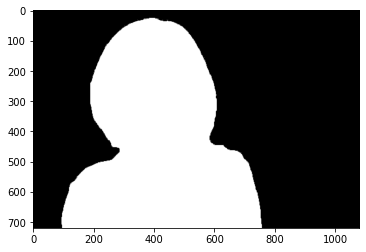

In [72]:
# all(): output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르면 0(False)
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

#### 원래 이미지와 겹쳐서 세그멘테이션이 잘 되었는지 확인해보자
>#### ✔️ `cv2.applyColorMap()`
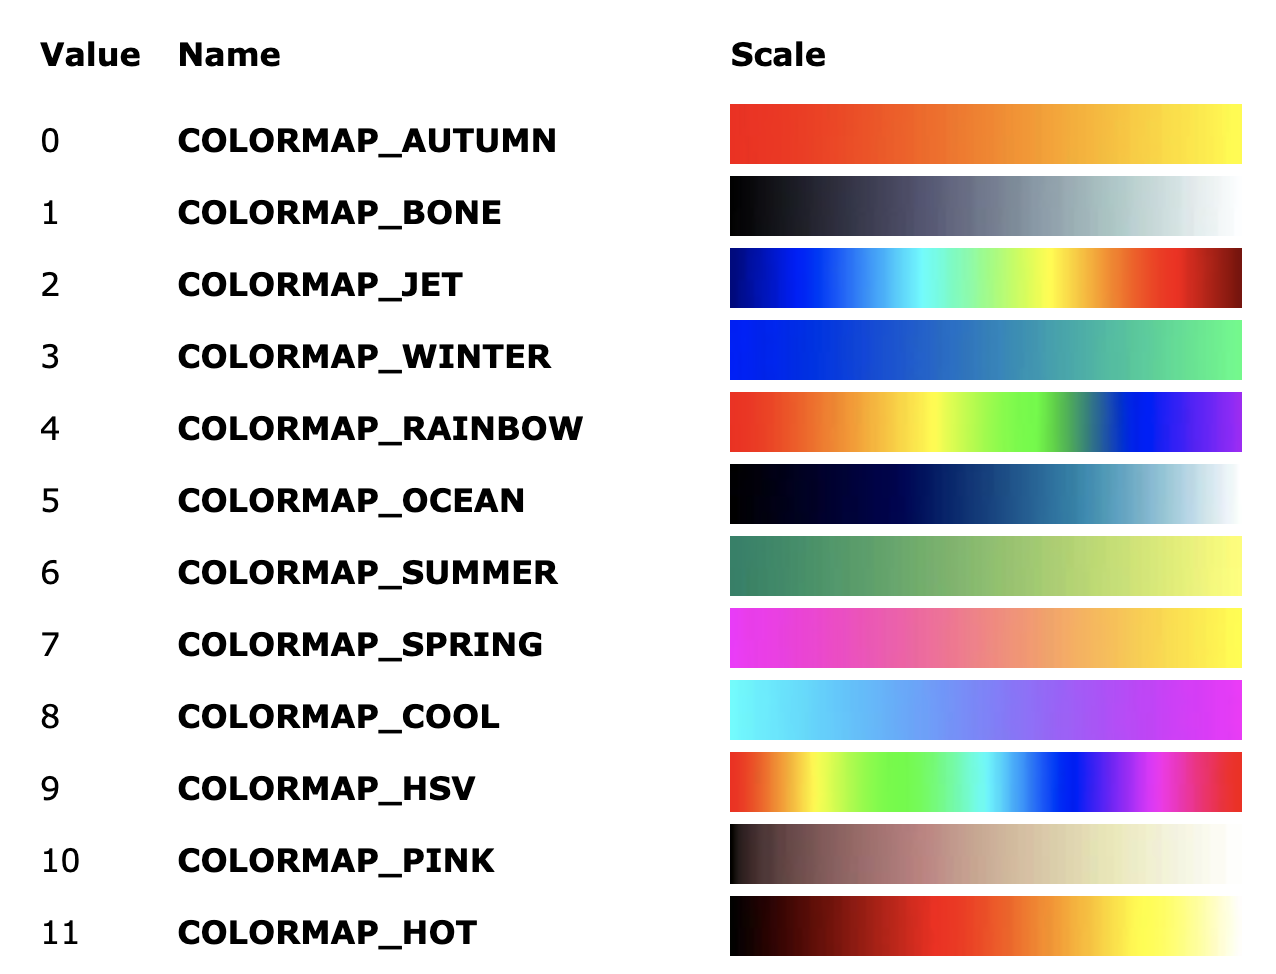
>#### ✔️ `cv2.addWeighted()`
: 두 개의 이미지에 가중치를 조절하여 덧셈함. 가중치가 더 큰 이미지가 좀 더 선명히 나타남`

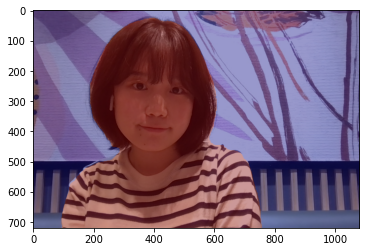

In [73]:
img_show = img_orig.copy()

# True와 False인 값을 각각 255, 0으로 바꿔주기
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 변경하기
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐보기
# 0.6과 0.4는 두 이미지 섞는 비율
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0) # 조절해보기

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 4. 배경 흐리게 하기
`blur` 함수 이용

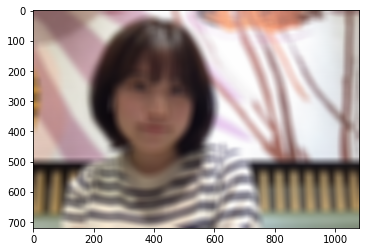

In [74]:
# (13, 13)은 blurring kernel size를 의미
# 다양하게 바꿔보기
img_orig_blur = cv2.blur(img_orig, (30, 30))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

#### 흐려진 이미지에서 세그멘테이션 마스크를 이용해 배경만 추출하기

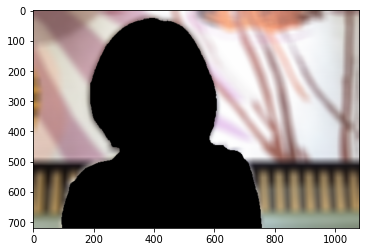

In [75]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR) # 배경 0, 사람 255
img_bg_mask = cv2.bitwise_not(img_mask_color) # 배경 255, 사람 0
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask) # 사람 그대로 0 - 배경에 blur
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

`bitwise_not` 함수를 통해 이미지가 반전되었다. 원래 마스크에선 배경이 0, 사람이 255였는데 `bitwise_not` 연산 이후엔 배경이 255, 사람이 0이 됨. <br/>
이렇게 반전된 세그멘테이션 결과를 이용해 이미지와 `bitwise_and` 연산을 수행하면 배경만 있는 영상 얻을 수 있다. 0과 어떤 수를 `bitewise_and` 연산을 해도 0이 되므로 사람이 0인 경우 사람이 있던 모든 픽셀이 0이 되어 사람이 사라지게 된다.

## 5. 흐린 배경과 원본 영상 합성

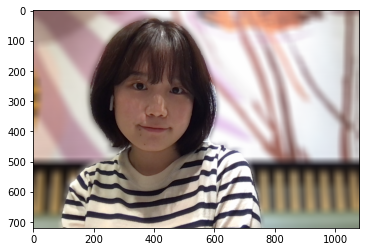

In [76]:
# 배경과 사람 합치자.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur) # 사람(255)이면 origin, 아니면 blur
# img_concat = np.where(img_bg_mask==255, img_bg_blur, img_orig)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_color (원본)을 사용할 경우 세그멘테이션 마스크가 255인 원본 이미지 값(사람)을 가져오고, 아닌 영역(0, 배경)은 블러된 이미지 값을 사용. `np.where(조건, 참일 때, 거짓일 때)`의 코드 사용 <br/>
(+) img_bg_mask일 경우 bitwise_not 연산을 한 것이기 때문에 반대로 작성해야 한다.

*****


# 🐬 프로젝트: 인물 모드 문제점 찾기
### Step 1. 인물모드 직접 해 보기
- 최소 3장 이상의 인물모드 사진 만들기 (인물 뿐만 아니라 동물도)
- 배경을 blur하지 않고 다른 이미지로 교체하는 크로마키 배경 합성도 시도해보자. <br/>

### Step 2. 사진에서 문제점 찾기
- 표시해보기!<br/>

### Step 3. 해결 방법 제안해보기
- 단순히 'xxx 기술을 이용한다.'가 아닌 우리가 선택한 기술이 DeepLab 모델의 Semenatic Segmentation이 만들어낸 Mask 영역에 어떻게 적용되어 문제점을 보완하게 되는지의 메커니즘이 포함된 솔루션이어야 함 <br/>

### Step 1. 인물모드 직접 해 보기
위의 예제에서 제 사진을 이용했기에 이번에는 고양이, 말 2마리,  자전거를 타는 사람, 아이유 총 4가지의 다양한 이미지를 이용했습니다. <br/>
1. 먼저 `고양이`이미지는 앞선 과정과는 조금 다르게 고양이 얼굴에 블러 처리를 하고, 배경에 포커싱을 맞췄습니다. <br/>
2. 다음 `말 2마리` 이미지는 동일한 말이라는 객체가 1개가 아닌 2개여도 둘 다 잘 인식을 할지 궁금해서 선택했습니다. <br/>
3. `자전거를 타는 사람`의 이미지는 한 이미지에 자전거와 사람, 자동차라는 세 가지 객체가 존재할 때 이 모두를 구분할 수 있는지를 판별하기 위해 시도해보았습니다.<br/>
4. 마지막 `아이유` 이미지에는  배경을 블러처리가 아니라 다른 이미지로 교체하는 크로마키 배경 합성을 시도해보았습니다.

(404, 546, 3)


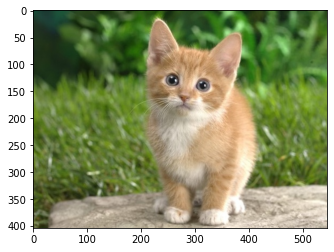

(724, 1096, 3)


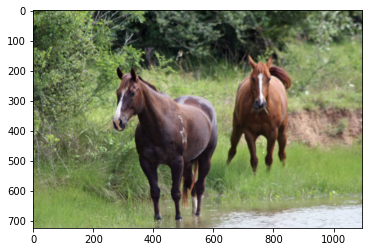

(648, 970, 3)


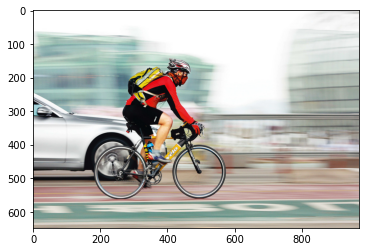

(460, 616, 3)


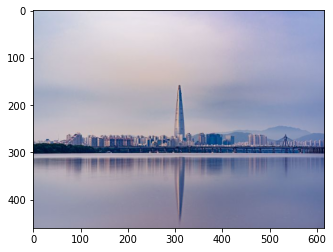

(1406, 1125, 3)


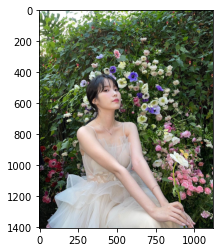

(335, 500, 3)


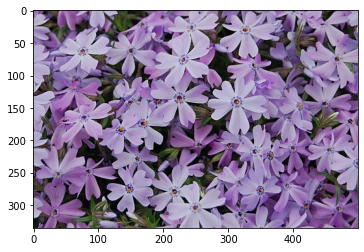

In [77]:
img_path_cat = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.png'  
img_orig_cat = cv2.imread(img_path_cat)

img_path_horse = os.getenv('HOME')+'/aiffel/human_segmentation/images/two_horses.png'  
img_orig_horse = cv2.imread(img_path_horse)

img_path_bic = os.getenv('HOME')+'/aiffel/human_segmentation/images/bicycle_person.png'  
img_orig_bic = cv2.imread(img_path_bic)

img_path_seoul = os.getenv('HOME')+'/aiffel/human_segmentation/images/seoul.png'  
img_orig_seoul = cv2.imread(img_path_seoul)

img_path_IU = os.getenv('HOME')+'/aiffel/human_segmentation/images/IU.png'  
img_orig_IU = cv2.imread(img_path_IU)

img_path_flower = os.getenv('HOME')+'/aiffel/human_segmentation/images/flower.png'  
img_orig_flower = cv2.imread(img_path_flower)

print(img_orig_cat.shape)
plt.imshow(cv2.cvtColor(img_orig_cat, cv2.COLOR_BGR2RGB))
plt.show()

print(img_orig_horse.shape)
plt.imshow(cv2.cvtColor(img_orig_horse, cv2.COLOR_BGR2RGB))
plt.show()

print(img_orig_bic.shape)
plt.imshow(cv2.cvtColor(img_orig_bic, cv2.COLOR_BGR2RGB))
plt.show()

# 자전거 타는 사람 배경으로 들어갈 이미지
print(img_orig_seoul.shape)
plt.imshow(cv2.cvtColor(img_orig_seoul, cv2.COLOR_BGR2RGB))
plt.show()

print(img_orig_IU.shape)
plt.imshow(cv2.cvtColor(img_orig_IU, cv2.COLOR_BGR2RGB))
plt.show()


# 아이유 이미지 배경으로 들어갈 이미지
print(img_orig_flower.shape)
plt.imshow(cv2.cvtColor(img_orig_flower, cv2.COLOR_BGR2RGB))
plt.show()

자전거 타는 사람의 배경엔 서울 이미지를, 아이유 이미지의 배경에는 꽃 이미지를 합성할 것입니다. 두 이미지를 합성하기 위해선 사진의 크기가 동일해야 하므로 배경이 될 이미지를 메인 이미지의 크기에 맞게 `resize`합니다.

In [78]:
print(img_orig_bic.shape)
print(img_orig_seoul.shape)

print('---------------')

print(img_orig_IU.shape)
print(img_orig_flower.shape)

(648, 970, 3)
(460, 616, 3)
---------------
(1406, 1125, 3)
(335, 500, 3)


(648, 970, 3)


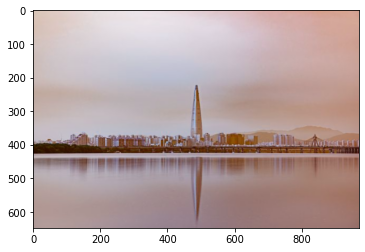

(1406, 1125, 3)


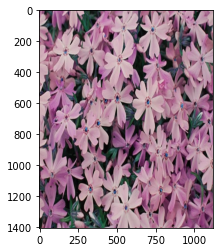

In [79]:
# 이미지 resize
img_seoul_resize = cv2.resize(img_orig_seoul, (970, 648))
img_flower_resize = cv2.resize(img_orig_flower, (1125, 1406))

print(img_seoul_resize.shape)
plt.imshow(img_seoul_resize)
plt.show()
print(img_flower_resize.shape)
plt.imshow(img_flower_resize)
plt.show()

##### (+) 배경의 크기를 확대했더니 이미지의 화질(색상)도 달라졌다.

#### 위에서 만든 세그멘테이션 모델에 이미지 입력하기

In [80]:
segvalues_cat, output_cat = model.segmentAsPascalvoc(img_path_cat)
segvalues_horse, output_horse = model.segmentAsPascalvoc(img_path_horse)
segvalues_bic, output_bic = model.segmentAsPascalvoc(img_path_bic)
segvalues_IU, output_IU = model.segmentAsPascalvoc(img_path_IU)

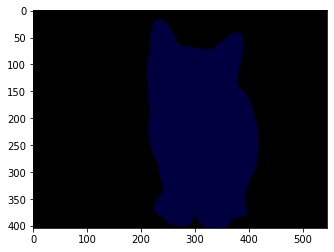

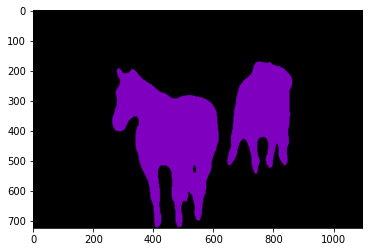

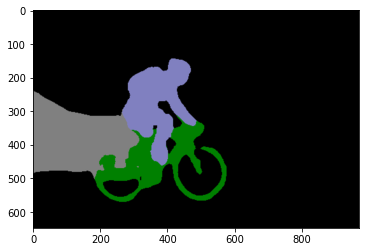

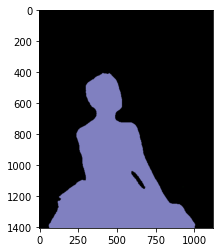

In [81]:
# output에서는 세그멘테이션 결과가 각각 다른 색으로 저장됨을 확인 가능하다.
plt.imshow(output_cat)
plt.show()

plt.imshow(output_horse)
plt.show()

plt.imshow(output_bic)
plt.show()

plt.imshow(output_IU)
plt.show()

#### Pascal Voc 데이터의 라벨 종류 확인해보기

In [82]:
print(LABEL_NAMES)

['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv']


`segvalues`에는 `class_ids`와 `masks`가 있다. `class_ids`를 통해 어떤 물체가 담겨있는지 알 수 있다.

In [83]:
segvalues_cat

{'class_ids': array([0, 8]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

3번째 사진에선 자전거와 사람, 그리고 배경에 자동차까지 3가지의 물체가 등장했다. 이를 모두 객체로 인식했는지 확인해보자

In [84]:
segvalues_bic # 잘 인식하구나

{'class_ids': array([ 0,  2,  7, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [85]:
for class_id in segvalues_cat['class_ids']:
    print(LABEL_NAMES[class_id]) # 0과 8(cat)를 LABEL_NAMES에서

print('---------------')
    
for class_id in segvalues_horse['class_ids']:
    print(LABEL_NAMES[class_id]) # 0과 13(horse)를 LABEL_NAMES에서
    
print('---------------')

for class_id in segvalues_bic['class_ids']:
    print(LABEL_NAMES[class_id]) # 0과 2(bicycle), 7(car), 15(person)를 LABEL_NAMES에서

print('---------------')

for class_id in segvalues_IU['class_ids']:
    print(LABEL_NAMES[class_id]) # 0과 7(potted plant), 15(person)를 LABEL_NAMES에서

background
cat
---------------
background
horse
---------------
background
bicycle
car
person
---------------
background
person
pottedplant


아이유의 사진에서 라벨 7인 potted plant(화분)도 함께 검출되었다. 예상치 못한 부분이었고, 우린 아이유만 구분할 것이기 때문에 라벨 15만 다뤄보자.

In [86]:
print(colormap[8]) # 고양이
print(colormap[13]) # 말
print(colormap[2]) # 자전거
print(colormap[7]) # 차
print(colormap[15]) # 사람

[64  0  0]
[192   0 128]
[  0 128   0]
[128 128 128]
[192 128 128]


In [87]:
# BGR을 RGB로 바꿔주기
seg_color_cat = (0, 0, 64)
seg_color_horse = (128, 0, 192)
seg_color_bic = (0, 128, 0)
seg_color_car = (128, 128, 128)
seg_color_person = (128, 128, 192)

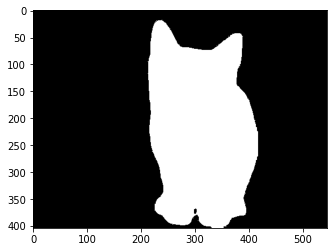

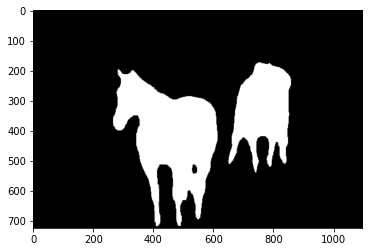

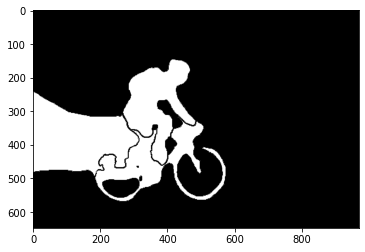

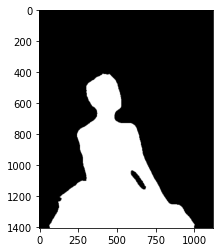

In [88]:
# all(): output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르면 0(False)
seg_map_cat = np.all(output_cat==seg_color_cat, axis=-1)
# print(seg_map_cat.shape)
plt.imshow(seg_map_cat, cmap='gray')
plt.show()

seg_map_horse = np.all(output_horse==seg_color_horse, axis=-1)
# print(seg_map_horse.shape)
plt.imshow(seg_map_horse, cmap='gray')
plt.show()

# numpy.logical_or()을 이용해 다중 조건 구현
# 3가지의 조건이어서 logical_or 함수를 두 번 적용했다.
seg_map_bic = np.all(np.logical_or(np.logical_or(output_bic==seg_color_bic, output_bic==seg_color_car), output_bic==seg_color_person), axis=-1)
# print(seg_map_bic.shape)
plt.imshow(seg_map_bic, cmap='gray')
plt.show()

seg_map_IU = np.all(output_IU==seg_color_person, axis=-1)
# print(seg_map_IU.shape)
plt.imshow(seg_map_IU, cmap='gray')
plt.show()

#### 원래 이미지와 겹쳐 세그멘테이션 잘 되었는지 확인하기

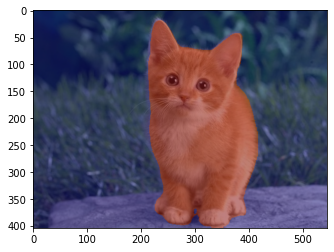

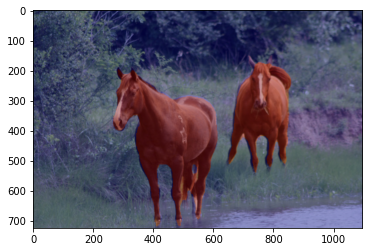

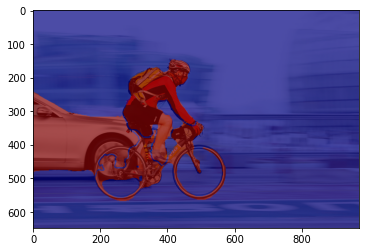

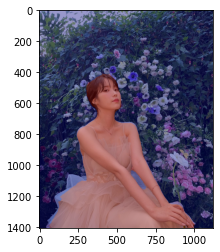

In [89]:
img_show_cat = img_orig_cat.copy()
img_show_horse = img_orig_horse.copy()
img_show_bic = img_orig_bic.copy()
img_show_IU = img_orig_IU.copy()

# True와 False인 값을 각각 255, 0으로 바꿔주기
img_mask_cat = seg_map_cat.astype(np.uint8) * 255
img_mask_horse = seg_map_horse.astype(np.uint8) * 255
img_mask_bic = seg_map_bic.astype(np.uint8) * 255
img_mask_IU = seg_map_IU.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 변경하기
color_mask_cat = cv2.applyColorMap(img_mask_cat, cv2.COLORMAP_JET)
color_mask_horse = cv2.applyColorMap(img_mask_horse, cv2.COLORMAP_JET)
color_mask_bic = cv2.applyColorMap(img_mask_bic, cv2.COLORMAP_JET)
color_mask_IU = cv2.applyColorMap(img_mask_IU, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐보기
# 0.6과 0.4는 두 이미지 섞는 비율
img_show_cat = cv2.addWeighted(img_show_cat, 0.5, color_mask_cat, 0.5, 0.0)
plt.imshow(cv2.cvtColor(img_show_cat, cv2.COLOR_BGR2RGB))
plt.show()

img_show_horse = cv2.addWeighted(img_show_horse, 0.6, color_mask_horse, 0.4, 0.0)
plt.imshow(cv2.cvtColor(img_show_horse, cv2.COLOR_BGR2RGB))
plt.show()

img_show_bic = cv2.addWeighted(img_show_bic, 0.3, color_mask_bic, 0.7, 0.0)
plt.imshow(cv2.cvtColor(img_show_bic, cv2.COLOR_BGR2RGB))
plt.show()

img_show_IU = cv2.addWeighted(img_show_IU, 0.6, color_mask_IU, 0.4, 0.0)
plt.imshow(cv2.cvtColor(img_show_IU, cv2.COLOR_BGR2RGB))
plt.show()

#### 블러(blur) 처리 해보기
블러처리 할 사진은 고양이, 말 사진 뿐

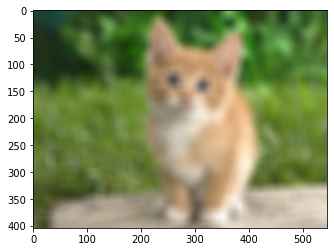

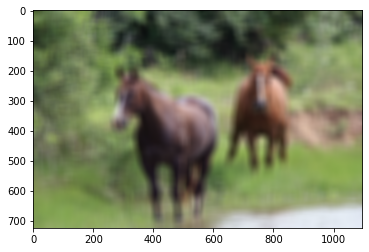

In [90]:
# (, )은 blurring kernel size를 의미
# 다양하게 바꿔보기
img_orig_blur_cat = cv2.blur(img_orig_cat, (20, 20))
plt.imshow(cv2.cvtColor(img_orig_blur_cat, cv2.COLOR_BGR2RGB))
plt.show()

img_orig_blur_horse = cv2.blur(img_orig_horse, (30, 30))
plt.imshow(cv2.cvtColor(img_orig_blur_horse, cv2.COLOR_BGR2RGB))
plt.show()

#### 흐려진 이미지에서 세그멘테이션 마스크를 이용해보기
1. 고양이를 블러처리 하고, 배경을 살려보기
2. 말은 살리고, 배경을 블러처리 하자.
> #### ❓ 굳이굳이 bitwise_not으로 두 값을 반전시키는 이유는?
아래에서 bitwise_and를 이용해 우리가 원하는(최종적으로 포커스를 주고 싶은) 객체를 0으로 만들어 bitwise_and 연산을 수행해 0인 부분은 모두 사라지게(검은색) 하고 싶기 때문이라고 생각한다.

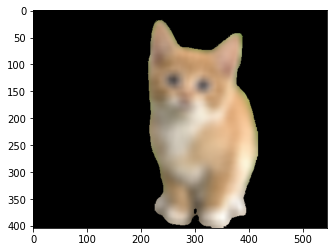

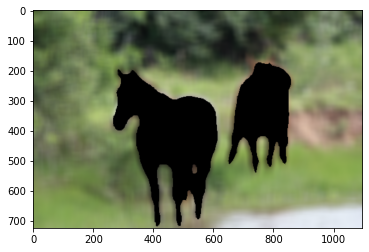

In [91]:
img_mask_color_cat = cv2.cvtColor(img_mask_cat, cv2.COLOR_GRAY2BGR) # 배경 0, 고양이 255
img_bg_blur_cat = cv2.bitwise_and(img_orig_blur_cat, img_mask_color_cat) # 배경 0 - 사라지게 함
plt.imshow(cv2.cvtColor(img_bg_blur_cat, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_color_horse = cv2.cvtColor(img_mask_horse, cv2.COLOR_GRAY2BGR) # 배경 0, 말 255
img_bg_mask_horse = cv2.bitwise_not(img_mask_color_horse) # 배경 255, 말 0
img_bg_blur_horse = cv2.bitwise_and(img_orig_blur_horse, img_bg_mask_horse) # 말 그대로 0 - 사라지게 함
plt.imshow(cv2.cvtColor(img_bg_blur_horse, cv2.COLOR_BGR2RGB))
plt.show()


# 자전거와 아이유 사진은 블러처리가 필요하지 않기 때문에 mask만 설정해주었다.
img_mask_color_bic = cv2.cvtColor(img_mask_bic, cv2.COLOR_GRAY2BGR)

img_mask_color_IU = cv2.cvtColor(img_mask_IU, cv2.COLOR_GRAY2BGR)


#### 배경과 사람 합치기
여기서 고양이는 배경이 아닌 고양이를 블러처리 할 것이기 때문에 `np.where(img_mask_color_cat==255, img_bg_blur_cat, img_orig_cat)` 라고 적거나 `np.where(img_mask_color_cat==0, img_orig_cat, img_bg_blur_cat)` 라고 작성해야 한다. <br/>
(+) 위 예제와 마찬가지로 horse의 경우 img_mask_color_horse가 아니라 img_bg_mask_horse 함수를 쓸 경우 반대로 작성해줘야 한다.

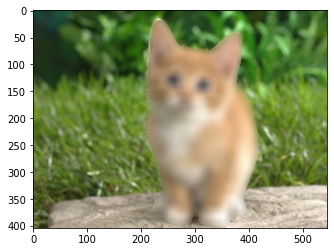

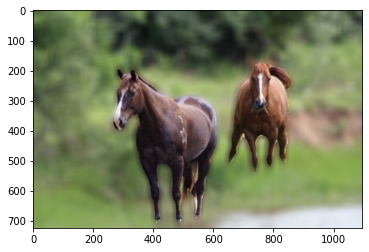

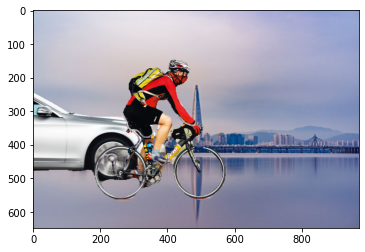

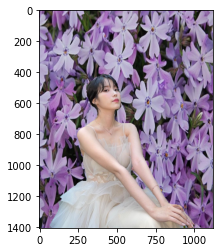

In [92]:
# 255는 객체, 0은 배경
img_concat_cat = np.where(img_mask_color_cat==255, img_bg_blur_cat, img_orig_cat) # 고양이(255)면 blur, 아니면 origin
plt.imshow(cv2.cvtColor(img_concat_cat, cv2.COLOR_BGR2RGB))
plt.show()

img_concat_horse = np.where(img_mask_color_horse==255, img_orig_horse, img_bg_blur_horse) # 말(255)면 origin, 아니면 blur
# img_concat_horse = np.where(img_bg_mask_horse==255, img_bg_blur_horse, img_orig_horse)
plt.imshow(cv2.cvtColor(img_concat_horse, cv2.COLOR_BGR2RGB))
plt.show()

img_concat_bic = np.where(img_mask_color_bic==255, img_orig_bic, img_seoul_resize) # 사람이면 bic사진, 아니면 seoul이미지
plt.imshow(cv2.cvtColor(img_concat_bic, cv2.COLOR_BGR2RGB))
plt.show()

img_concat_IU = np.where(img_mask_color_IU==255, img_orig_IU, img_flower_resize) # 아이유면 IU사진, 아니면 flower사진
plt.imshow(cv2.cvtColor(img_concat_IU, cv2.COLOR_BGR2RGB))
plt.show()


## Step 2. 사진에서 문제점 찾기

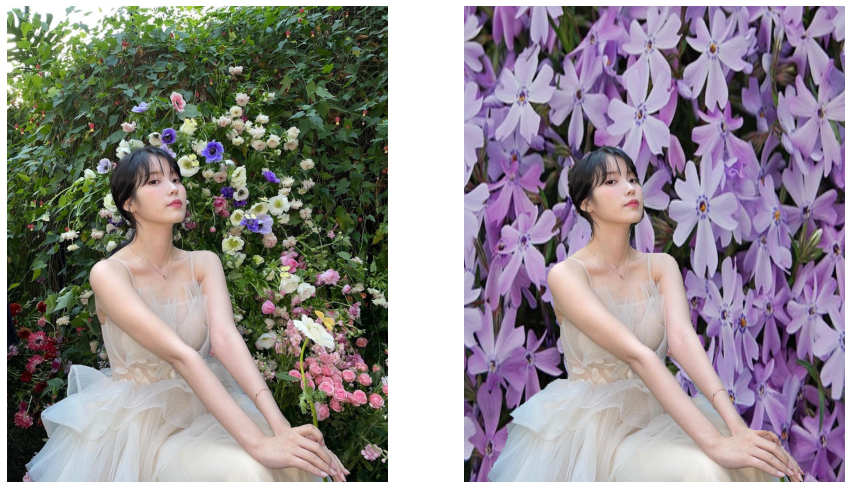

In [93]:
fig = plt.figure(figsize=(15, 20))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.imshow(cv2.cvtColor(img_orig_IU, cv2.COLOR_BGR2RGB))
ax1.axis('off')

ax2.imshow(cv2.cvtColor(img_concat_IU, cv2.COLOR_BGR2RGB))
ax2.axis('off')

plt.show()

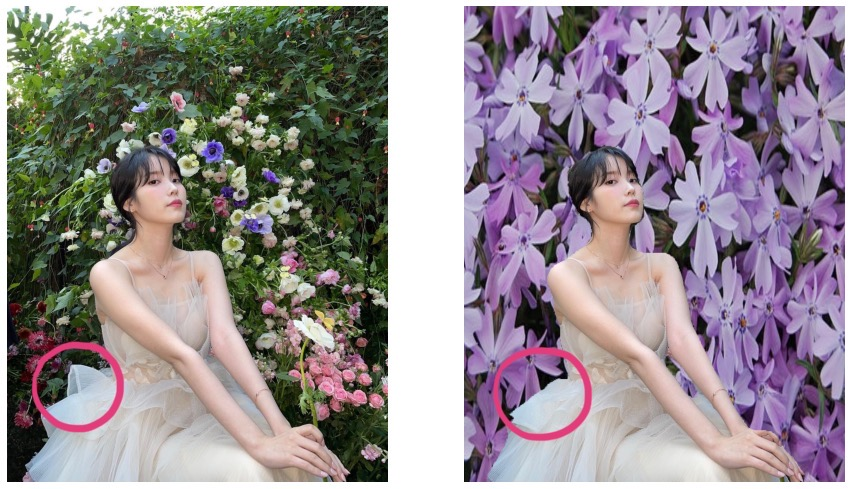

아이유 사진에서 왼쪽 아래의 드레스에서 뒷부분 레이스가 짤린 것을 볼 수 있다.
- 위에서 class_id로 발견한 객체의 index를 확인해보았을 때 7번의 potted plant도 함께 검출되었는데, **드레스를 화분**으로 인식한 듯 하다.

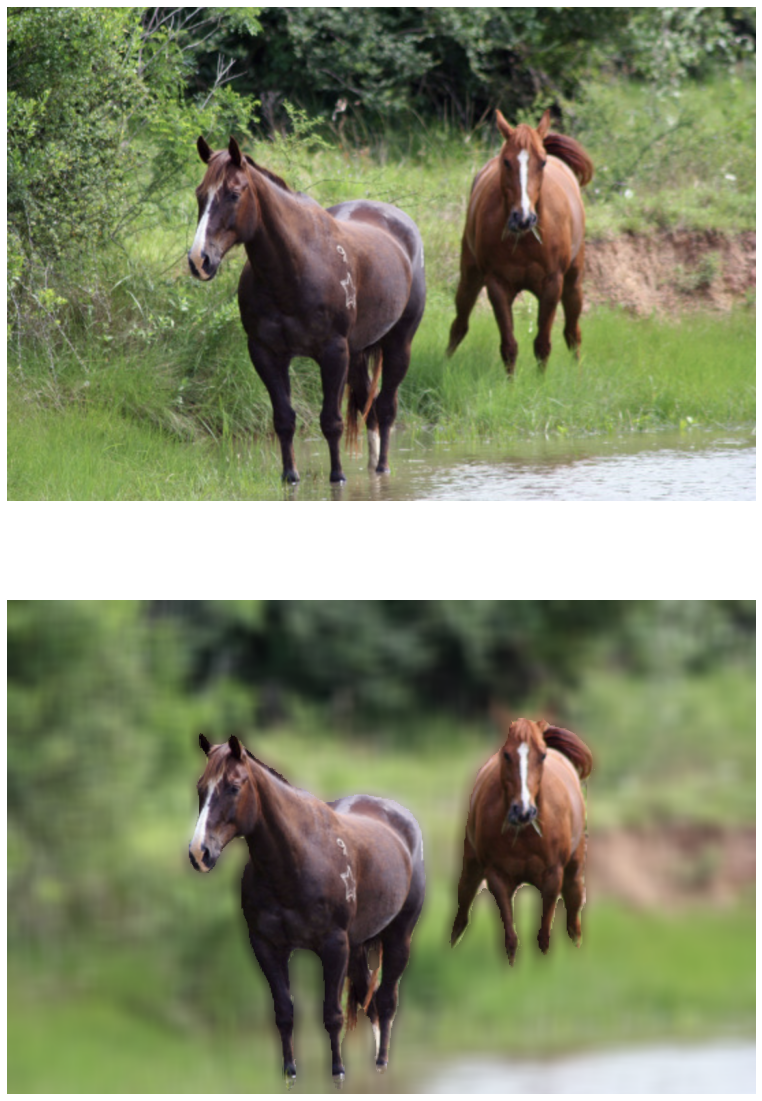

In [101]:
fig = plt.figure(figsize=(30, 20))

ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.imshow(cv2.cvtColor(img_orig_horse, cv2.COLOR_BGR2RGB))
ax1.axis('off')

ax2.imshow(cv2.cvtColor(img_concat_horse, cv2.COLOR_BGR2RGB))
ax2.axis('off')

plt.show()

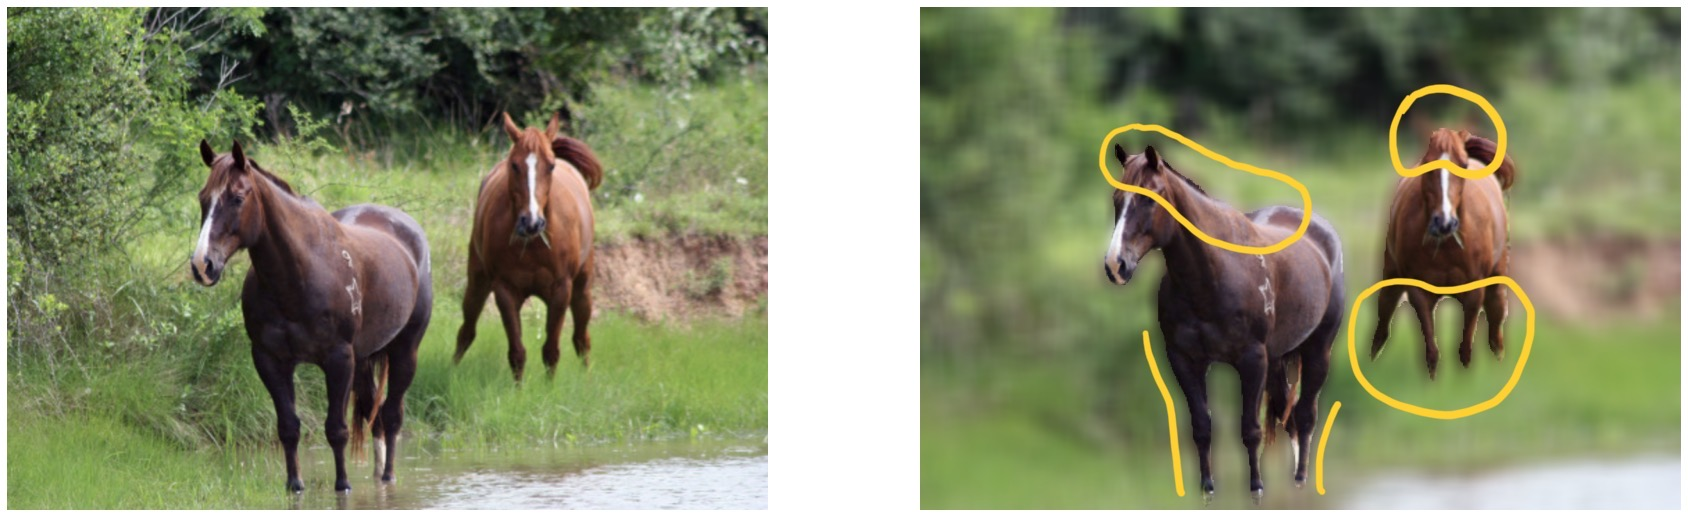

말 사진을 보면 경계가 말들과 배경과의 경계가 굉장히 이분법적으로 나뉜듯한 느낌을 받을 수 있다. 마치 **말들이 공중에 떠있는 듯한 느낌**이 발생한다. 특히나 오른쪽 말의 귀, 다리 또한 블러처리가 되어버렸고, 블러 효과를 높였더니 다리의 외곽이 깎인 것 처럼 보인다.
- 즉 **블러 처리된 배경과 객체의 경계선이 나뉘어 부자연스러운 문제**가 발생한다 !

## Step 3. 해결 방법 제안해보기

#### 세그멘테이션의 한계
- semantic segmentation의 부정확성
- 피사계심도를 이용한 아웃포커싱은 섬세하게 segmentation 가능하지만, 이를 따라한 semantic segmantation 기법은 정확도가 1.0이 되지 않는 한 구현하기 힘듬 <br/>

#### 피사계 심도 (DOF; depth of field)
사진에서 초점이 맞은 것으로 인식되는 범위. 렌즈에서 초점이 맞는 거리(Focus Distance)는 딱 한 부분(Focus Point)인데, 이 부분을 중심으로 서서히 흐려지는 현상이 나타난다. 이 초점이 맞는 범위를 `피사계 심도`라고 한다.
- 심도가 얕으면 흔히 말하는 아웃포커싱이 된 것이고 (더 블러 처리)
- 심도가 깊으면 초점이 전체에 맞아 있을 것이다! (덜 블러 처리) <br/>

#### (1) 3D 카메라 활용하기
- 최근 이미지센서 시장을 주도할 '[3D 이미지 센서][1]'는 사물의 거리(심도)를 측정함으로써 더 정밀하게 물체나 동작을 인식해 이를 3D 이미지로 구현할 수 있게 된다.
- 3D 이미지센서의 동작 원리 중 ToF(Time fo Flight)방식에는 '간접 ToF(Indirect ToF)', '직접 ToF(Direct ToF)'가 있는데 이 중 각광받는 방식은 `D-ToF`이다.
- `D-ToF` 방식은 사물에 조사해 반사된 펄스 신호들이 이미지센서에 도착하는 시간을 측정함으로써 물체까지의 거리를 탐지하는 방식이다. 

[1]:https://news.skhynix.co.kr/post/next-gen-3d

#### (2) 소프트웨어 기술 활용하기
- 구글의 [struct2Depth][2] <br/>
[2]:https://sites.google.com/view/struct2depth

#### (3) 다른 기술과 융합해보기
- 구글 pixel4에는 IR(적외선) 카메라가 달려 있다.
- 이를 통해 [3d depth sensing][3]이 가능함
[3]:https://ai.googleblog.com/2020/04/udepth-real-time-3d-depth-sensing-on.html

***

마스크 이미지가 0과 255처럼 극단적으로 나눠져 있어 경계선이 생기는 문제가 발생한다고 판단했다. 이를 위해서 blur 함수가 아닌 부드러운 곡선의 형태를 띄는 `Gaussian Blur`를 사용하면 해결할 수 있을 것이다.

### 이미지 필터링
: 각 알고리즘에 의해 픽셀 값을 변경해 이미지에 효과를 주는 역할을 하며 이를 통해 이미지를 **흐리게, 날카롭게, 뚜렷하게, 노이즈 제거** 등 다양한 효과를 줄 수 있습니다. <br/>

- blur()
- GaussianBlur()
- medianBlur()
- bilateralFilter() <br/>
https://jvvp.tistory.com/1032 <br/>

### ✔️ 가우시안 필터 (Gaussian Filter)
: 가우시안 분포(Gaussian distribution) 함수를 근사해 생성한 필터 마스크를 사용하는 필터링 기법
- 영상의 가우시안 필터에서는 평균이 0인 가우시안 분포 함수를 사용한다.
- opencv에서 가우시안 필터링을 수행하기 위해 GaussianBlur() 함수를 제공함
- blur()와의 차이점은 같이 흐림 효과를 주지만 전체적으로 밀도가 동일한 **백색 노이즈를 제거**하는 데 효과적이라 한다.

아래 코드는 혼돈 방지를 위해 위에서 했던 작업을 다시 적어준 코드이다.

In [95]:
img_path_horse = os.getenv('HOME')+'/aiffel/human_segmentation/images/two_horses.png'  
img_orig_horse = cv2.imread(img_path_horse)

segvalues_horse, output_horse = model.segmentAsPascalvoc(img_path_horse)

seg_color_horse = (128, 0, 192)
seg_map_horse = np.all(output_horse==seg_color_horse, axis=-1)

# True와 False인 값을 각각 255, 0으로 바꿔주기
img_mask_horse = seg_map_horse.astype(np.uint8) * 255
print(img_mask_horse.shape)

(724, 1096)


### `GaussianBlur` 사용해보기

In [96]:
# img_mask_horse의 채널을 원본 사진과 맞게 3 channel로 바꿔준다.
img_mask_horse_3C = np.repeat(np.expand_dims(img_mask_horse, axis=2), 3, axis=2).astype(np.uint8)
print(img_mask_horse_3C.shape)

# 원본 이미지를 가우시안 Blur 처리한다.
orig_horse_Gblur = cv2.GaussianBlur(img_orig_horse, (65, 65), 0)

# 마스크 이미지를 가우시안 Blur 처리한다.
img_horse_Gmask = (cv2.GaussianBlur(img_mask_horse_3C, (31, 31), 65, 65) / 255).astype(np.float32)

# 마스크와 이미지를 더해준다.
image_horse_blur = img_horse_Gmask*img_orig_horse.astype(np.float32)

# 1-마스크를 해줘서 Blur 처리한 원본에서 배경만 뽑아낸다.
img_bg_horse_mask = (1-img_horse_Gmask) * orig_horse_Gblur.astype(np.float32)
img_horse_output = (image_horse_blur + img_bg_horse_mask).astype(np.uint8)

(724, 1096, 3)


#### ❓ np.expand.dims(axis=2)
>✔️ expand.dims(): 차원을 늘리는 함수
>- axis를 필수적으로 입력해야 함
>- axis=2 또는 axis=-1: 깊이를 의미한다.
<br/> <br/>
>`np.expand_dims(img_mask_horse, axis=2), 3)` 이므로 img_mask_horse라는 (724, 1096) 행렬에 `depth`를 3만큼 추가하여 결국 (724, 1096, 3) 행렬이 되는 것이다.

#### ❓ cv2.GaussianBlur(src, ksize, sigmaX, sigmaY, borderType=None)
>- src: 입력 영상, 각 채널 별로 처리됨
>- ksize: 가우시안 커널 크기
>- sigmaX: x방향 표준편차(0: auto)
>- sigmaY(optimal): Y방향 표준편차(default: sigmaX)
>- borderType(optioinal): 외곽 테두리 보정 방식
<br/>

>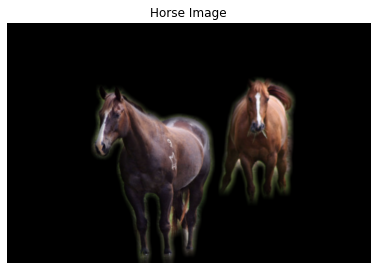
>: ksize=(31, 31)
>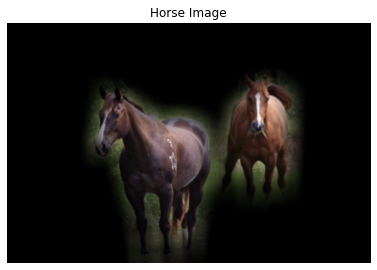
>: ksize=(101, 101)

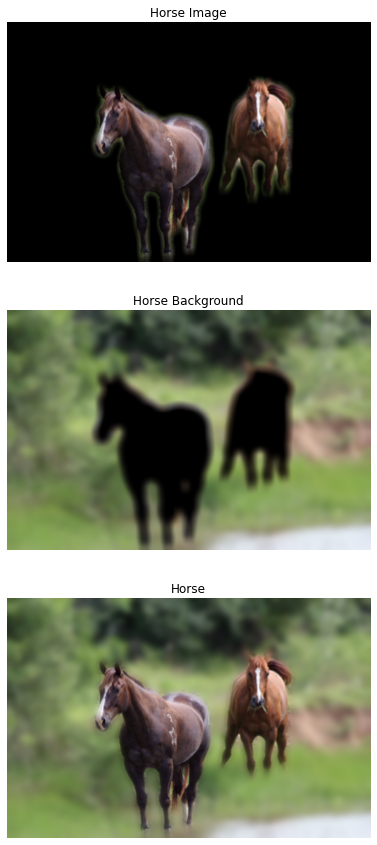

In [97]:
# GaussianBlur 처리한 부분을 확인하기
fig = plt.figure(figsize=(20, 15)) 

ax = plt.subplot(3, 1, 1)
plt.imshow(cv2.cvtColor(image_horse_blur.astype(np.uint8),cv2.COLOR_BGR2RGB))
plt.title('Horse Image')
plt.axis('off')
ax = plt.subplot(3, 1, 2)
plt.imshow(cv2.cvtColor(img_bg_horse_mask.astype(np.uint8),cv2.COLOR_BGR2RGB))
plt.title('Horse Background')
plt.axis('off')
ax = plt.subplot(3, 1, 3)
plt.imshow(cv2.cvtColor(img_horse_output,cv2.COLOR_BGR2RGB))
plt.title('Horse')
plt.axis('off')
plt.show()

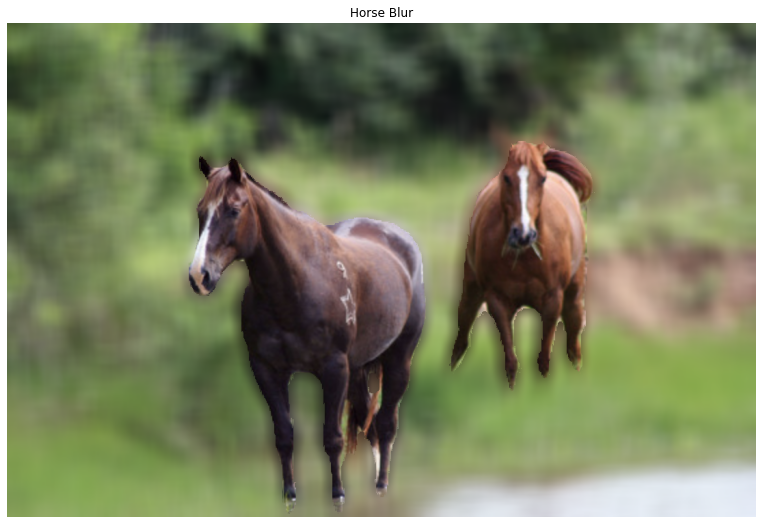

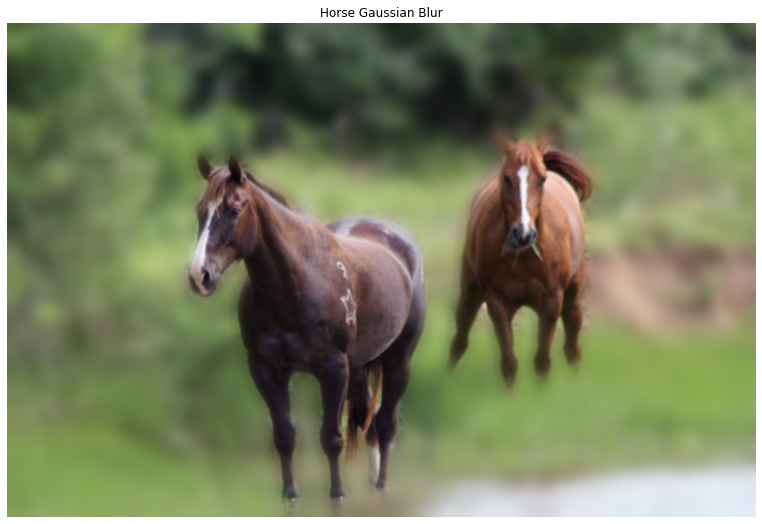

In [98]:
# 그냥 blur 함수를 처리한 이미지와 GaussianBlur 함수를 처리한 이미지 비교
fig = plt.figure(figsize=(30, 20))
ax = plt.subplot(2, 1, 1)
plt.imshow(cv2.cvtColor(img_concat_horse, cv2.COLOR_BGR2RGB))
plt.title('Horse Blur')
plt.axis('off')

fig = plt.figure(figsize=(30, 20))
ax = plt.subplot(2, 1, 2)
plt.imshow(cv2.cvtColor(img_horse_output,cv2.COLOR_BGR2RGB))
plt.title('Horse Gaussian Blur')
plt.axis('off')
plt.show()

두 이미지 모두 뒷배경은 비슷한 정도로 blur처리 되었다. 하지만 객체와 background의 경계선을 비교해보면 GaussianBlur을 사용한 이미지에서 경계가 훨씬 부드럽게 나누어져 허공에 떠있는 듯한 느낌은 줄어들었다.
- 하지만 귀와 다리 쪽에서 여전히 함께 블러처리된 부분은 이미지 필터링의 한계점이라 느꼈고, 이를 극복하기 위해선 좀 더 고화질의 사진을 이용하거나 새로운 기술을 이용해야 한다 판단했다.

***

## 🧤 3d sensing
위에서도 간단히 설명한 3d depth 인식 기술은 Computational Camera의 한 종류로써 기존의 2D에서는 할 수 없었던 이미지 각 픽셀의 깊이 값을 계산할 수 있는 기술이다. 크게 스테레오, 구조광, ToF 방식이 있는데 이 중 가장 각광받는 기술은 ToF 방식이다. <br/>
기존의 픽셀의 RGB, 채도, contrast 정보 뿐 아니라 **픽셀의 깊이 정보**까지 습득이 가능하다. <br/>
#### 다음은 아래 논문에서 발췌한 내용입니다.
- [단일 카메라를 이용한 3D 깊이 추정 방법][1]
[1]:http://www.kibme.org/resources/journal/20190411153555246.pdf
<br/>

아직 논문까지 읽고 이해하여 정리하긴 쉽지 않아 읽어보기만 하였다! <br/>
음, 지금까지 단순히 2차원 이미지의 구조를 통해 객체를 인지하고 segmentation한 것보다는 픽셀의 depth 정보까지 이해하여 객체간의 거리를 계산해 구분한다면 좀 더 좋은 성능을 낼 수 있지 않을까 생각이 든다. <br/>
- DFD기술은 단일 카메라만을 이용해 3d 깊이 추정이 가능한데, 일단 **물체의 경계**를 추출하는 것이 굉장히 중요하다.
1. 물체의 경계가 아닌 표면에서는 흐림 정도를 계산하기 어렵기 때문에 먼저 사진에서 경계선 검출을 통해 객체와 배경을 분리한다.
2. 초점이 맞지 않는 물체의 경계는 경계면 주변이 흐려저 아래 '그림 2'의 첫 번째 박스와 같은 모양이 된다. 
3. 흐림 효과를 극대화하기 위해 가우시안 커널을 이용하고 기존의 흐린 경계, 다시 흐려지게 한 영상의 흐린 경계들의 미분값을 구해 그 비율로 흐림 정도를 추정한다.
4. 다음 DFD를 수행하여 최종적으로 깊이 맵이 출력되는 구조를 가진다.

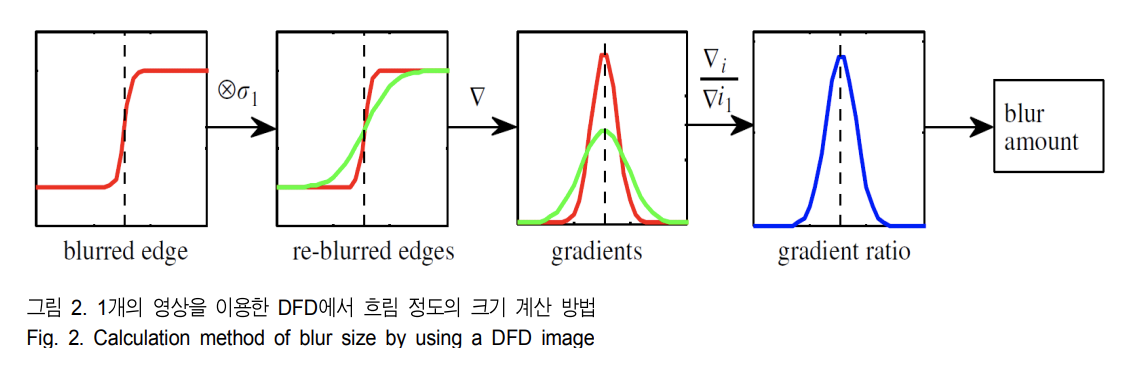
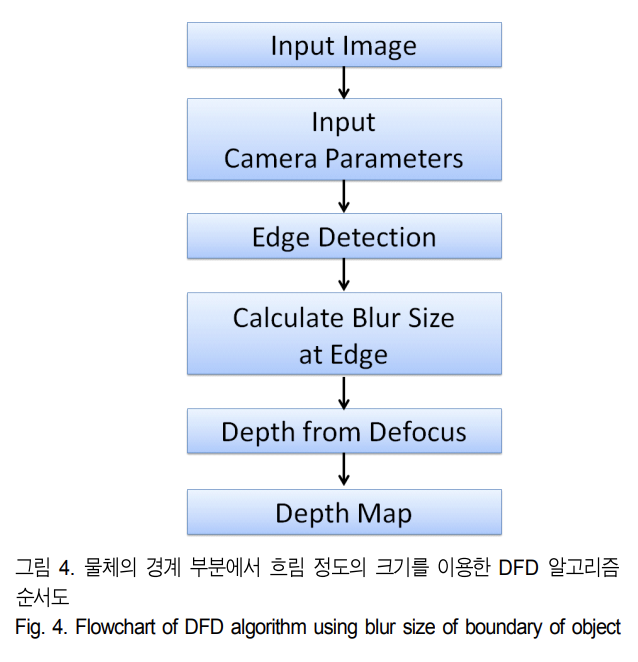

****


# 🧤 회고

✔️ 지난 번 Face Sticker 노드에 이어 이번 노드에서도 이미지 처리에 대해 배울 수 있어 굉장히 흥미로웠고 재밌었다. opencv에 더 관심이 생기고 앞으로 좀 더 공부해보며 다양한 기능들을 접해보고 싶다.

✔️ blur 함수를 적용해보며 그동안 이용했던 온라인 화상 플랫폼 (zoom, meet 등)에서 배경화면에 blur처리를 하는 기능이 떠올랐다. 아직은 단순히 이미지의 배경에 blur처리하는 방법을 배웠지만 (물론 당연히 구현 과정은 단순하지 않았음 호호 ,,) zoom처럼 실시간으로 움직이는 객체에게 blur를 한다는 것은 얼마나 더 정교하고 복잡한 기술인 것일까 생각이 들었다.

✔️ blur 함수와 GaussianBlur의 차이점을 시각적으로 확인할 수 있었다. blur 함수만 사용했을 때도 충분히 잘 처리되었다고 생각했는데 자세히 확대해보니 처리된 부분과 처리되지 않은 부분이 강하게 구분된만큼 위의 그림처럼 둥둥 떠있는 듯한 부자연스러운 문제가 발생했다. 이는 마스크가 극단적으로 나뉘는 세그멘테이션의 단점이라는 것을 배웠고, GaussianBlur의 부드러운 경계에 대해 찾아 공부해볼 수 있었다.

✔️ 처음 seoul 사진을 이용하였을 땐 자전거에 탄 사람만 있는 줄 알고 뒤에 자동차가 있다는 사실은 인지하지 못했다. 그러다 segmentation 모델에 넣은 뒤 class_ids를 출력해보니 인덱스가 총 4개라는 걸 본 뒤에야 알아차릴 수 있었다. 이렇게 사람이 인식하지 못하는 경우를 컴퓨터가 보완해 알려줄 수 있구나 .. 라는 것도 깨달았다. 아이유 사진에서도 마찬가지였다.

✔️ 3d depth sensing, struc2Depth 등 다양한 기술들에 대해 찾아보았는데 사실 깊게 이해가 되지 않았다. 이는 개인적으로 더 보완해야할 부분이라고 생각하고, 이런 기술들이 존재하는만큼 현재 뛰어난 객체 인식 기술을 이용한 유용한 플랫폼들이 존재한다고 생각한다.

✔️ 번외로 이미지를 resize하였더니 색상이 변하였다. resize하며 픽셀 바이트값이 늘어나(줄어들어) 일어난 일인가라고 생각을 했는데, 최종적으로 합쳤을 땐 원본과 동일한 색감으로 나와 헷갈리는 부분이었다.